In [41]:
import pandas as pd
import os
# os.chdir("..")
# os.chdir("data")
df = pd.read_csv('./data/train_metadata.csv')
print(df.describe())

         Class Injured Gender  Item                      Filename
count      500     500    500   500                           500
unique       2       2      2     4                           500
top     Zombie   False   Male  None  train_dataset/test_00000.png
freq       257     312    260   207                             1


# train cnn example

In [42]:
import torch, timm, PIL,os, sklearn, gc
import sklearn.preprocessing
import sklearn.model_selection
from timm.scheduler import CosineLRScheduler
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.nn.functional as F

# define image transformations and augmentations (if you want)

In [43]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# define dataset

In [44]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms, base_dir ="./data",):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        
        img_path = row['Filename']
        target = row['state']
        
        image = Image.open(os.path.join(self.base_dir,img_path))
        image = train_transform(image)
        return image, torch.tensor(target).long()

# read data and get holdout set
would be ideal to set random state to ensure the splits are consistent

In [45]:
test_df = pd.read_csv('./data/test_metadata.csv')
train_df = pd.read_csv('./data/train_metadata.csv')

In [46]:
import sys; sys.path.append('../')
from endpoints.data_parser import datarow_to_state
from gameplay.enums import State
# encode categorical data into numbers
enc = sklearn.preprocessing.LabelEncoder()

train_df['state'] = train_df.apply(datarow_to_state, axis=1)
test_df['state'] = test_df.apply(datarow_to_state, axis=1)

enc.fit(train_df.state)
from gameplay.humanoid import Humanoid
enc.classes_ = np.array(Humanoid.get_all_states(), dtype=object)
train_df.state = enc.transform(train_df.state)
test_df.state = enc.transform(test_df.state)

# begin setting up training pipeline
use class weights since this is imbalanced classification

In [47]:
#hyperparams
model_name = 'default' #'maxvit_tiny_tf_512' # resnet10t
batch_size = 16
learning_rate = 2e-4
weight_decay = 1e-8 # l2 regularization
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_grad_norm = 100 #max gradient value

epochs_warmup=1

In [48]:
train_ds = Dataset(train_df,train_transform)
val_ds = Dataset(test_df,val_transform)
loader_train = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                 num_workers=0, pin_memory=False, shuffle=True, drop_last=True)
loader_val = torch.utils.data.DataLoader(val_ds , batch_size=batch_size,
                 num_workers=0, pin_memory=False)

In [49]:
class_weights=sklearn.utils.class_weight.compute_class_weight('balanced',classes=np.unique(train_df.state),y=train_df.state)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [50]:
# Create a neural net class
class DefaultCNN(nn.Module):

    # Defining the Constructor
    def __init__(self, num_classes_=4):
        # In the init function, we define each layer we will use in our model
        super(DefaultCNN, self).__init__()

        # Our images are RGB, so we have input channels = 3.
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=2, stride=1, padding=1)

        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)

        # Our 512x512 image tensors will be pooled twice with a kernel size of 2. 512/2/2 is 128  32.
        # This means that our feature tensors are now 128 x 128, and we've generated 24 of them
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=128 * 128 * 24, out_features=num_classes_)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))

        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)

        # Flatten
        x = x.view(-1, 128 * 128 * 24)
        # Feed to fully-connected layer to predict class

        x = self.fc(x)
        return x
if model_name == 'default':
    model = DefaultCNN()
else:
    model =  timm.create_model(model_name, num_classes=len(class_weights),pretrained=True)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

nbatch = len(loader_train)
warmup = epochs_warmup * nbatch  # number of warmup steps
nsteps = epochs * nbatch        # number of total steps
scheduler = CosineLRScheduler(optimizer,
              warmup_t=warmup, warmup_lr_init=1e-6, warmup_prefix=True, # 1 epoch of warmup
              t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine

gc.collect()

5825

# validation loop

In [51]:
def evaluate(model, loader_val):
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []
    for img, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_pred = model(img)
        loss = criterion(y_pred, y)

        n_sum += n
        loss_sum += n * loss.item()
        
        
        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(torch.nn.functional.softmax(y_pred,1).cpu().detach().numpy())

        del loss, y_pred, img, y
        gc.collect()

    loss_val = loss_sum / n_sum

    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    ret = {'loss': loss_val,
           'y': y,
           'y_pred': y_pred,}
    gc.collect()
    return ret

# training loop

In [52]:
# out = model(torch.zeros(2,3,512,512))
# out

In [53]:
# torch.nn.functional.softmax(out,1)

In [54]:
best_loss = 1000
torch.cuda.empty_cache()
for iepoch in range(epochs):
    model.train()
    for ibatch, (img, y) in tqdm(enumerate(loader_train)):
        img = img.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        
        y_pred = model(img)
        loss = criterion(y_pred, y)

        loss_train = loss.item()

        loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),max_grad_norm)

        optimizer.step()
        
        scheduler.step(iepoch * nbatch + ibatch + 1)
        
        gc.collect()
    validation_results = evaluate(model, loader_val)
    print(validation_results['loss'])
    best_loss = min(best_loss,validation_results['loss'])
    if best_loss ==validation_results['loss']:
        ofilename = 'baseline.pth'
        torch.save(model.state_dict(), ofilename)
    gc.collect()

31it [00:40,  1.30s/it]


1.539155933856964


31it [00:40,  1.29s/it]


1.5182210779190064


31it [00:39,  1.28s/it]


1.1555778980255127


31it [00:39,  1.27s/it]


1.0867631387710572


31it [00:37,  1.22s/it]


1.1023898458480834


In [55]:
y_pred = np.array([np.argmax(x) for x in validation_results['y_pred']])
y_pred

array([0, 1, 1, 0, 3, 3, 3, 1, 0, 1, 3, 0, 0, 2, 0, 1, 3, 3, 2, 3, 1, 1,
       0, 0, 3, 3, 1, 3, 1, 0, 2, 3, 0, 3, 2, 2, 0, 3, 1, 1, 0, 1, 1, 3,
       0, 0, 2, 0, 1, 2, 3, 0, 0, 0, 1, 0, 0, 0, 1, 3, 3, 0, 2, 3, 3, 1,
       0, 1, 1, 3, 0, 3, 0, 1, 0, 1, 3, 1, 0, 0, 2, 0, 1, 1, 1, 1, 0, 2,
       1, 0, 3, 1, 3, 0, 1, 3, 1, 3, 3, 3, 1, 3, 1, 0, 1, 0, 3, 3, 1, 1,
       3, 0, 1, 1, 1, 1, 1, 3, 3, 0, 1, 0, 3, 1, 2, 0, 1, 3, 1, 1, 0, 2,
       1, 3, 0, 2, 0, 0, 1, 3, 3, 3, 2, 1, 1, 2, 3, 3, 1, 0, 1, 1, 2, 0,
       1, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 1, 3, 1, 3, 3, 1, 0, 3, 2, 3, 3,
       3, 1, 1, 0, 2, 3, 1, 2, 3, 0, 1, 1, 3, 0, 2, 0, 1, 1, 1, 1, 1, 0,
       3, 3], dtype=int64)

In [56]:
y_pred[0]

0

In [57]:
validation_results['y']

array([1, 1, 1, 1, 3, 3, 2, 0, 1, 3, 1, 1, 1, 3, 0, 1, 3, 2, 3, 2, 1, 1,
       0, 1, 3, 2, 1, 3, 1, 3, 3, 3, 0, 3, 3, 2, 1, 3, 1, 1, 1, 1, 0, 3,
       0, 3, 3, 0, 0, 3, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 3, 0, 2, 2, 2, 1,
       1, 1, 1, 1, 3, 3, 0, 1, 0, 1, 3, 0, 1, 0, 3, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 2, 0, 3, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 0, 3, 2, 0, 1,
       3, 1, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 3, 1, 2, 1, 1, 2, 2, 1, 1, 2,
       1, 3, 2, 2, 1, 0, 0, 2, 3, 1, 3, 1, 0, 3, 3, 2, 1, 0, 1, 1, 3, 1,
       1, 1, 0, 0, 1, 3, 1, 0, 2, 1, 0, 1, 3, 0, 3, 2, 0, 1, 1, 3, 2, 3,
       2, 0, 1, 0, 3, 0, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1, 0,
       3, 0], dtype=int64)

# view confusion matrix of predicted values

In [58]:
matrix = sklearn.metrics.confusion_matrix(validation_results['y'],y_pred,)

In [59]:
matrix

array([[23, 20,  1,  2],
       [29, 46,  0,  6],
       [ 2,  1,  7, 19],
       [ 3,  1, 12, 28]], dtype=int64)

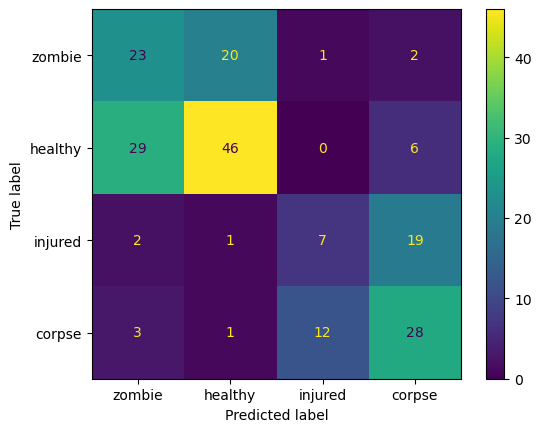

In [61]:
sklearn.metrics.ConfusionMatrixDisplay(matrix,display_labels=  enc.classes_).plot()
plt.savefig('baseline_cmatrix.png')
plt.show()